In [ ]:
#https://github.com/alvarorgaz/Deep-Learning-KTH/blob/master/Assignment%201/Assignment%201.ipynb
#http://home.mit.bme.hu/~hadhazi/Oktatas/NN18/dem3/html_demo/CIFAR-10Demo.html
#https://neptune.ai/blog/data-augmentation-in-python

In [1]:
import numpy as np
from numpy import random
from sklearn.metrics import precision_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import math

In [2]:
def LoadBatch(filename):
    """ Copied from the dataset website """
    import pickle
    with open('Dataset/'+filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def montage(W):
	""" Display the image for each label in W """
	import matplotlib.pyplot as plt
	fig, ax = plt.subplots(2,5)
	for i in range(2):
		for j in range(5):
			im  = W[i*5+j,:].reshape(32,32,3, order='F')
			sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
			sim = sim.transpose(1,0,2)
			ax[i][j].imshow(sim, interpolation='nearest')
			ax[i][j].set_title("y="+str(5*i+j))
			ax[i][j].axis('off')
	plt.show()
    
 

In [3]:
train = LoadBatch('data_batch_1')
validation = LoadBatch('data_batch_2')
test = LoadBatch('test_batch')

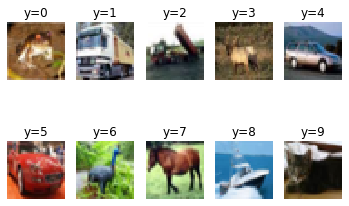

In [4]:
montage(train[b'data'])

In [4]:
def separete_file(filename):#exercise 1, task 1
    data = filename[b'data']
    labels = filename[b'labels']
    y=np.array(filename[b'labels'])#(10000,)
    one_hot = np.zeros((len(y), 10), dtype=int)
    one_hot[np.arange(len(y)), y] = 1 #(10000,10)
    
    return np.transpose(y), np.transpose(one_hot), np.transpose(data)

def normalize(data, column_means, column_stds):
    column_means = data.mean(axis=0)
    column_stds = data.std(axis=0)
    data = data - column_means
    data = data / column_stds
    return data

def init_parameters(mean, std, size):
    return random.normal(mean, std, size)

def EvaluateClassifier(X, W, b):
    s = np.dot(W,X)+ b
    softmax = np.exp(s)/np.sum(np.exp(s), axis=0)
    return softmax

def ComputeCost(X, Y, W, b, lambd):
    P = EvaluateClassifier(X, W, b)
    regulaizer = lambd*np.sum(np.square(W))
    N = X.shape[1]
    square_matrix = -np.dot(np.transpose(Y), np.log(P))
    sum_diag = np.trace(square_matrix) 
    cost = (1/N) * sum_diag + regulaizer
    return cost

def ComputeAccuracy(X, y, W, b):
    P = EvaluateClassifier(X, W, b)
    estimated_y = np.argmax(P, axis=0)
    accurancy = accuracy_score(y, estimated_y)
    return accurancy

def ComputeGradsNum(X, Y, P, W, b, lamda, h):
	#P = EvaluateClassifier(X, W, b)
	no 	= 	W.shape[0]
	d 	= 	X.shape[0]

	grad_W = np.zeros(W.shape);
	grad_b = np.zeros((no, 1));

	c = ComputeCost(X, Y, W, b, lamda);
	
	for i in range(len(b)):
		b_try = np.array(b)
		b_try[i] += h
		c2 = ComputeCost(X, Y, W, b_try, lamda)
		grad_b[i] = (c2-c) / h

	for i in range(W.shape[0]):
		for j in range(W.shape[1]):
			W_try = np.array(W)
			W_try[i,j] += h
			c2 = ComputeCost(X, Y, W_try, b, lamda)
			grad_W[i,j] = (c2-c) / h

	return [grad_W, grad_b]
    
def ComputeGradients(X, Y, W, b, lambd):
    P = EvaluateClassifier(X, W, b)
    G_batch = -(Y - P)
    N = X.shape[1]
    grad_W = np.add(np.dot(G_batch,np.transpose(X)) / N , 2*lambd*W)
    grad_b = np.dot(G_batch,np.ones((X.shape[1],1))) / N
    return grad_W, grad_b


def compare_gradients(g1,g2, eps):
    num = abs(g1-g2).sum()
    denom = max(eps, abs(g1+g2).sum())
    if num/denom < num/eps:
        print('the two gradients are the same')
    return num/denom, num/eps


def MiniBatchGD(X, Y, y, X_val, Y_val, y_val, n_batch, eta, n_epochs, W, b, lambd, decay_eta= None):
    N = X.shape[1]
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    
    for epoch in range(n_epochs):
    
        for batch in range(0, N, n_batch):
            grad_W, grad_b = ComputeGradients(X[:,batch:batch+n_batch], Y[:,batch:batch+n_batch], 
                                              W, b, lambd)
            W -= eta*grad_W
            b -= eta*grad_b
            
        train_acc.append(ComputeAccuracy(X, y, W, b))
        train_loss.append(ComputeCost(X, Y, W, b, lambd))
        
        val_acc.append(ComputeAccuracy(X_val, y_val, W, b))
        val_loss.append(ComputeCost(X_val, Y_val, W, b, lambd))
        
        if decay_eta is not None:
            epochs_drop = 10.0
            eta *= math.pow(decay_eta, math.floor((1+epoch)/epochs_drop))
        
        
    return W, b, train_acc, train_loss, val_acc, val_loss

def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, color='red', label='train loss: '+str(round(train_loss[-1], 3)))
    plt.plot(val_loss, color='blue', label='validation loss: '+str(round(val_loss[-1], 3)))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    #plt.show()
    
def plot_accurancy(train_acc, val_acc):
    plt.plot(train_acc, color='red', label='train accurancy: '+str(round(train_acc[-1], 3)))
    plt.plot(val_acc, color='blue', label='validation accurancy: '+str(round(val_acc[-1], 3)))
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accurancy")
    #plt.show()
    
    

In [5]:
#separate the file into: 
#y : a vector of length n containing the label for each image
#one_hot : one-hot representation, has size Kxd
#images: contains the image pixel data, has size d×n
y_train,one_hot_train,images_train=separete_file(train)
y_valid,one_hot_valid,images_valid=separete_file(validation)
y_test,one_hot_test,images_test=separete_file(test)

#normalize the train, val, and test data with the train's means and standard deviations
column_means = images_train.mean(axis=0)#train's means
column_stds = images_train.std(axis=0)#traon's stds
images_train_norm = normalize(images_train, column_means, column_stds)
images_valid_norm = normalize(images_valid, column_means, column_stds)
images_test_norm = normalize(images_test, column_means, column_stds)


W = random.normal(0, 0.01, (10, 3072))#initialize weight matrix
b = random.normal(0, 0.01, (10, 1))#initialize bias vector
P=EvaluateClassifier(images_train_norm[:,:1000],W,b)#probability for each label for the image in the corresponding column


# gradient of the cost function for the first 1000 images
forward = ComputeCost(images_train_norm[:,:1000], one_hot_train[:,:1000], W, b, 0.1)


#numerically computed gradients
g_W,g_b=ComputeGradsNum(images_train_norm[:,:100], one_hot_train[:,:100], P[:,:100], W, b, 0, 1e-06)
#analytically computed gradients
G_W,G_b=ComputeGradients(images_train_norm[:,:100], one_hot_train[:,:100], W, b,0)

compare_gradients(g_b,G_b,1e-06)#if the score in position [0] of the tuple is lower, then the two gradients are the same

the two gradients are the same


(6.034125297149775e-07, 0.43032244433430233)

### Minibacth: lambda=0, n epochs=40, n batch=100, eta=.001

In [6]:
W = init_parameters(0, 0.01, (10, 3072))#initialize weight matrix
b = init_parameters(0, 0.01, (10, 1))#initialize bias vector
W, b, train_acc, train_loss, valid_acc, valid_loss  = MiniBatchGD(images_train_norm, one_hot_train, y_train, 
                                                                  images_valid_norm, one_hot_valid, y_valid,
                                                                   100, 0.001, 40, W, b, 0, None)

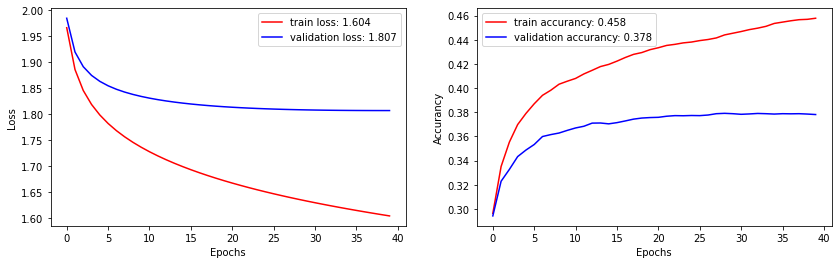

In [7]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plot_loss(train_loss, valid_loss)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc)

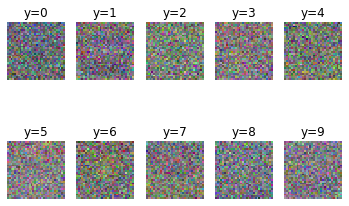

In [83]:
montage(W)

### Minibacth: lambda=0, n epochs=40, n batch=100, eta=.1

In [176]:
W = init_parameters(0, 0.01, (10, 3072))#initialize weight matrix
b = init_parameters(0, 0.01, (10, 1))#initialize bias vector
W, b, train_acc, train_loss, valid_acc, valid_loss  = MiniBatchGD(images_train_norm, one_hot_train, y_train, 
                                                                  images_valid_norm, one_hot_valid, y_valid,
                                                                   100, 0.1, 40, W, b, 0, None)

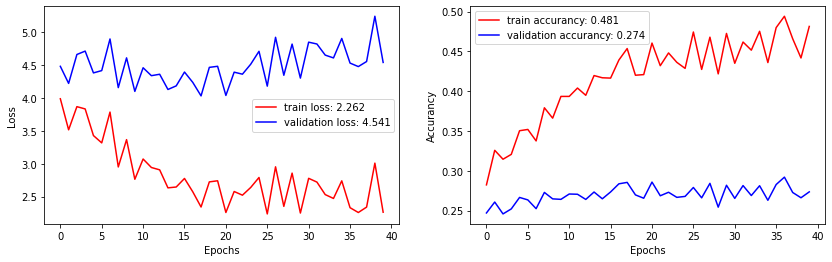

In [177]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plot_loss(train_loss, valid_loss)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc)

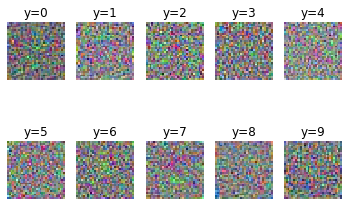

In [102]:
montage(W)

### Minibacth: lambda=0.1, n epochs=40, n batch=100, eta=.001

In [178]:
W = init_parameters(0, 0.01, (10, 3072))#initialize weight matrix
b = init_parameters(0, 0.01, (10, 1))#initialize bias vector
W, b, train_acc, train_loss, valid_acc, valid_loss  = MiniBatchGD(images_train_norm, one_hot_train, y_train, 
                                                                  images_valid_norm, one_hot_valid, y_valid,
                                                                   100, 0.001, 40, W, b, 0.1, None)

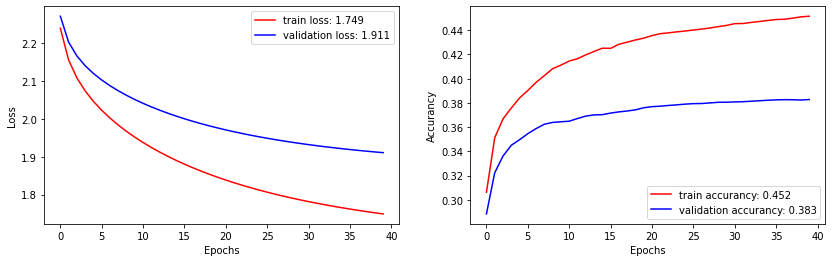

In [179]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plot_loss(train_loss, valid_loss)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc)

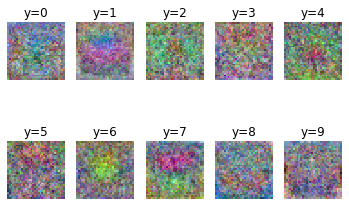

In [109]:
montage(W)

### Minibacth: lambda=1, n epochs=40, n batch=100, eta=.001

In [181]:
W = init_parameters(0, 0.01, (10, 3072))#initialize weight matrix
b = init_parameters(0, 0.01, (10, 1))#initialize bias vector
W, b, train_acc, train_loss, valid_acc, valid_loss  = MiniBatchGD(images_train_norm, one_hot_train, y_train, 
                                                                  images_valid_norm, one_hot_valid, y_valid,
                                                                   100, 0.001, 40, W, b, 1, None)

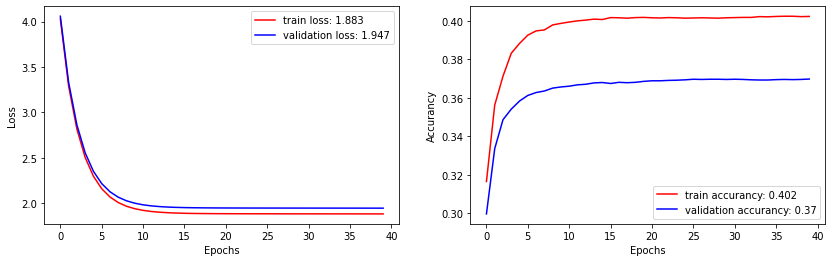

In [182]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plot_loss(train_loss, valid_loss)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc)

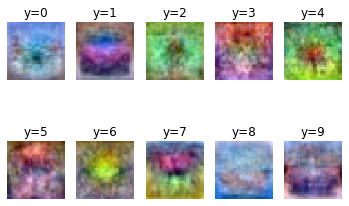

In [112]:
montage(W)

### BONUS POINT:  performance of the network

In [8]:
def BatchGD(X, Y, y, X_val, Y_val, y_val, eta, n_epochs, W, b, lambd, eta_decay):
    N = X.shape[1]
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    
    for epoch in range(n_epochs):
    
        grad_W, grad_b = ComputeGradients(X, Y, W, b, lambd)
        W -= eta*grad_W
        b -= eta*grad_b
            
        train_acc.append(ComputeAccuracy(X, y, W, b))
        train_loss.append(ComputeCost(X, Y, W, b, lambd))
        
        val_acc.append(ComputeAccuracy(X_val, y_val, W, b))
        val_loss.append(ComputeCost(X_val, Y_val, W, b, lambd))
        
        if eta_decay is not None:
            eta *= eta_decay
             
    return W, b, train_acc, train_loss, val_acc, val_loss


def flip_image(img):
    flipped = np.fliplr(np.reshape(img, (32, 32, 3), order='F'))
    flipped = np.reshape(flipped, img.shape, order='F')
    return flipped


def flip_em(X, p=0.5):
    to_flip = np.where(np.random.binomial(1, p, X.shape[1]) == 1)[0]
    print(to_flip)
    flip_X = X.copy()
    for image in to_flip:
        flip_X[:, image] = flip_image(X[:, image])
    return flip_X

def grid_search(X, Y, y, X_val, Y_val, y_val, W, b,lambdas, etas, n_batches):

    grid_search = pd.DataFrame({'lambda':[], 'eta':[], 'n_batch':[], 'valid_accurancy':[]})
    for i, (lambd, eta, n_batch) in enumerate(list(itertools.product(*[lambdas, etas, n_batches]))):

        W, b, _, _, valid_acc, valid_loss =MiniBatchGD(X, Y, y, X_val, Y_val, y_val, n_batch, 
                                                       eta, 40, W, b, lambd, None)
        grid_search = grid_search.append({'eta':eta, 'lambda':lambd, 'n_batch':n_batch,
                                          'valid_accurancy':valid_acc[-1]}, ignore_index=True)
    grid_search.sort_values(['valid_accurancy'], inplace=True)
    return grid_search



### Use all the available training data for training

In [184]:
W = init_parameters(0, 0.01, (10, 3072))#initialize weight matrix
b = init_parameters(0, 0.01, (10, 1))#initialize bias vector

index = np.random.choice(images_valid_norm.shape[1], 1000, replace=False) 
valid_1000 = images_valid_norm[:,index]
one_hot_1000 = one_hot_valid[:,index]
y_1000 = y_valid[index]

W, b, train_acc, train_loss, valid_acc, valid_loss  = BatchGD(images_train_norm, one_hot_train, y_train, 
                                                                  valid_1000, one_hot_1000, y_1000,
                                                                   0.025, 40, W, b, 0.1, None)

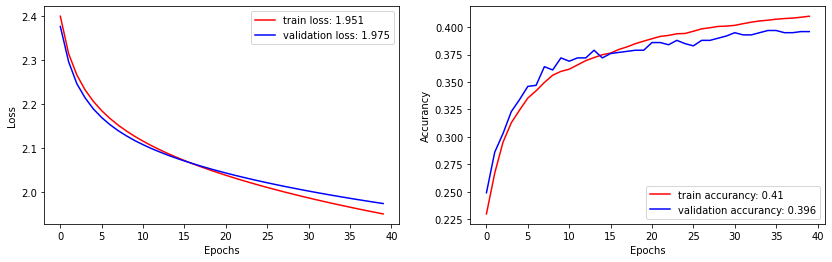

In [185]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plot_loss(train_loss, valid_loss)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc)

### Augment your training data 

In [190]:
augmented_data_train = flip_em(images_train_norm, p=0.5)
W = init_parameters(0, 0.01, (10, 3072))#initialize weight matrix
b = init_parameters(0, 0.01, (10, 1))#initialize bias vector
W, b, train_acc, train_loss, valid_acc, valid_loss  = MiniBatchGD(augmented_data_train, one_hot_train, y_train, 
                                                                  images_valid_norm, one_hot_valid, y_valid,
                                                                   100, 0.001, 40, W, b, 0, None)

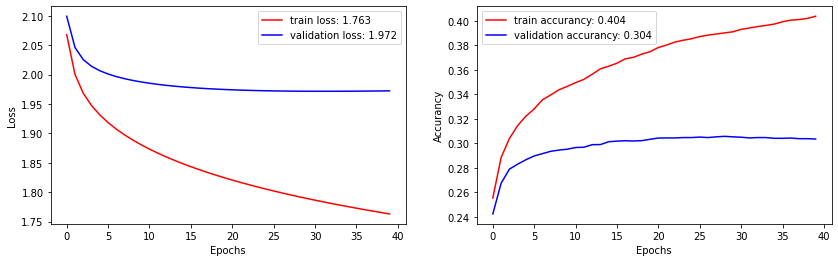

In [191]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plot_loss(train_loss, valid_loss)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc)

### Grid search

In [170]:
W = init_parameters(0, 0.01, (10, 3072))#initialize weight matrix
b = init_parameters(0, 0.01, (10, 1))#initialize bias vector
grid_df = grid_search(images_train_norm, one_hot_train, y_train, images_valid_norm, one_hot_valid, y_valid,
            W, b,lambdas=[0, 0.1, 1], etas=[0.00001, 0.0001, 0.001], n_batches = [10, 100, 200])
grid_df

,lambda,eta,n_batch,valid_accurancy
6,0.0,0.00100,10.0,0.3404
0,0.0,0.00001,10.0,0.3458
8,0.0,0.00100,200.0,0.3471
7,0.0,0.00100,100.0,0.3472
24,1.0,0.00100,10.0,0.3473
1,0.0,0.00001,100.0,0.3486
2,0.0,0.00001,200.0,0.3494
11,0.1,0.00001,200.0,0.3505
10,0.1,0.00001,100.0,0.3506
9,0.1,0.00001,10.0,0.3507


###  decaying the learning rate

In [61]:
W = init_parameters(0, 0.01, (10, 3072))#initialize weight matrix
b = init_parameters(0, 0.01, (10, 1))#initialize bias vector
W, b, train_acc, train_loss, valid_acc, valid_loss  = MiniBatchGD(images_train_norm, one_hot_train, y_train, 
                                                                  images_valid_norm, one_hot_valid, y_valid,
                                                                   100, 0.01, 40, W, b, 0.1, 0.10)

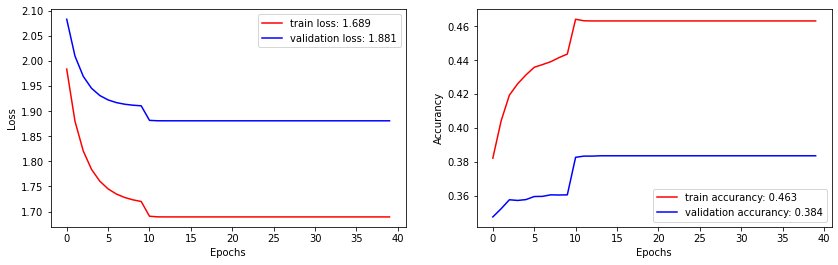

In [62]:
fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plot_loss(train_loss, valid_loss)
fig.add_subplot(122)
plot_accurancy(train_acc, valid_acc)